# 线性神经网络

### 线性回归by hand
#### 理论
数学模型:
$$
\hat y = \mathbf w^T\mathbf x
$$
回归问题一般选MSE做损失函数：
$$
L(\mathbf w,b) = \frac 1 n\sum_{i=1}^n \frac 1 2 \big(\mathbf w^T\mathbf x +b-y^{(i)}\big)^2
$$
目标：
$$
\mathbf w^{best},b^{best} = \operatorname*\argmin _{\mathbf w,b} L(\mathbf w,b)
$$


另：一条重要结论  
在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。证明过程：  
于假设显性模型的输出中增加了高斯噪声
$$y=\mathbf w^T\mathbf x + b + \epsilon, 其中 \epsilon \sim \mathcal N(0,\sigma^2) $$
因此可以写出给定x观测到y的似然：
$$P(y|\mathbf x) = \frac 1 {\sqrt {2\pi}\sigma}exp\Big(-\frac {1} {2\sigma^2} (y - \mathbf w^T\mathbf x - b) \Big)$$
然后根据极大似然估计: **模型参数的最优值是使整个数据集的似然最大的值**。整个数据集都发生的似然为（样本集满足i.i.d假设情况下）：
$$
\mathbf w^{best},b^{best}=\argmax_{\mathbf w,b} p(\mathbf y | \mathbf X) = \argmax_{\mathbf w,b}\prod_{i=1}^{n}p(y^{(i)}|\mathbf x^{(i)})
 $$
对目标函数p(y|X)取负对数得到损失函数：
$$
-\log  p(\mathbf y | \mathbf X) = \sum_{i=1}^n \frac 1 2 \log (2\pi \sigma^2) + \frac 1 {2\sigma^2}\Big( y^{(i)} - \mathbf w^T\mathbf x^{(i)} - b\Big)^2
$$
最后一个式子即等价于均方误差MSE


In [1]:
%matplotlib inline
import torch
import numpy as np
from utils.timer import Timer
from utils.accumulator import Accumulator
from utils.animation import Animator


使用设备类型: mps
前5个特征: tensor([[ 1.5961,  0.4450],
        [ 0.2862,  0.0172],
        [ 0.6560,  2.1830],
        [ 0.6620,  0.5896],
        [-0.4978, -0.8111]], device='mps:0'), 
前5个标签:tensor([[ 5.8738],
        [ 4.7209],
        [-1.9125],
        [ 3.5174],
        [ 5.9592]], device='mps:0')
形状:feature[1000, 2], labeltorch.Size([1000, 1])


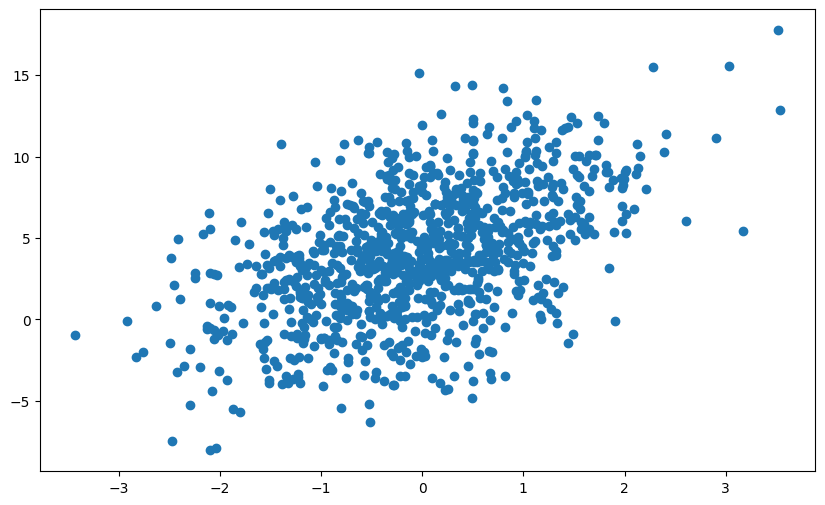

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'使用设备类型: {device}')


def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)),device=device)
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape,device=device)
    return X, y[..., None] ## 为啥要升维？

true_w = torch.tensor([2, -3.4],dtype=torch.float32,device=device)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(f'前5个特征: {features[:5]}, \n前5个标签:{labels[:5]}\n形状:feature{list(features.shape)}, label{labels.shape}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# 散点图的x和y的shape要一致，因此要features, labels)会报错
x = features[:, 0].squeeze() # 这里不 squeeze 也可以，因为 scatter 会自动处理 1 维张量
y = labels.squeeze()
plt.scatter(x.cpu(), y.cpu())
plt.show()

In [3]:
import random

# 训练相关准备
# 随机迭代
def data_iter(batch_size, features, labels):
    num = len(features)
    indices = list(range(num))
    random.shuffle(indices)
    for i in range (0,num,batch_size):
        batch_indices = indices[i:min(i+batch_size,num)]
        yield features[batch_indices],labels[batch_indices]
# 初始化模型参数
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break
w = torch.normal(0,0.01,(2,1),requires_grad=True,device=device)
b = torch.zeros(1,requires_grad=True,device=device)

# 模型输出函数
def line_regression(X:torch.Tensor,w:torch.Tensor,b:torch.Tensor):
    return X.matmul(w) + b
# 损失函数
def mse_loss(y:torch.Tensor,y_hat:torch.Tensor):
    return ((y.squeeze() - y_hat.squeeze())**2)/2
# 优化方法，注意这里为什么要除以batch_size?
def sgd(params:list[torch.Tensor], lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size
            param.grad.zero_() ## 注意这里要清零




tensor([[-2.0979, -0.2923],
        [ 1.5303,  0.0650],
        [-0.2393, -1.6583],
        [ 1.0056,  1.1119],
        [-0.5756,  0.3042],
        [-0.2212,  2.1351],
        [-0.4679,  0.0279],
        [-0.4165, -0.4224],
        [-0.6376, -0.0881],
        [-0.9113, -0.7076]], device='mps:0') 
 tensor([[ 1.0148],
        [ 7.0271],
        [ 9.3601],
        [ 2.4334],
        [ 2.0106],
        [-3.4906],
        [ 3.1738],
        [ 4.8008],
        [ 3.2235],
        [ 4.7831]], device='mps:0')


In [4]:
# 开始训练
lr = 0.03
epoch_num = 5
net = line_regression
loss = mse_loss

for epoch_idx in range(epoch_num):
    for X,y in data_iter(batch_size,features,labels):
        y_hat = net(X,w,b)
        l = loss(y,y_hat)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(labels,net(features,w,b))
        print(f'epoch{epoch_idx+1}, mean loss {float(train_l.mean()):.5f}')
print(f'finshed train, ground truth w:{true_w.tolist()},b:{true_b}\nour model param w:{w.tolist()},b:{b.tolist()}')

epoch1, mean loss 0.04634
epoch2, mean loss 0.00018
epoch3, mean loss 0.00005
epoch4, mean loss 0.00005
epoch5, mean loss 0.00005
finshed train, ground truth w:[2.0, -3.4000000953674316],b:4.2
our model param w:[[2.000143051147461], [-3.4011874198913574]],b:[4.199872970581055]


### 总结一下
先说一个误区：MSE的计算公式是包含求平均这个操作的
$$
MSE = \frac 1 n \sum_{i=1}^n (y^{(i)} - \hat y^{(i)})
$$
但是李沐的代码里，mse计算的时候并没有计算这个1/n的平均，但是在sgd里减梯度的时候除以了一个batch_size

模型训练三要素：
- net：模型本身，其实是一个将输入的批量样本映射成一个输出的映射函数，它的参数包含**批量输入的特征X、模型参数（包含w，b）**
- loss：损失函数，只负责将模型输出的估计值和真实的样本标签（两个都是批量的）映射为一个损失值（也是批量），它的输入只有**估计值和真实标签**
- 优化函数：主要负责对模型本身进行参数更新

每个batch的处理流程：
1. 批量特征数据输入模型，得到批量估计输出
2. 根据估计输出和标签计算loss（loss也是批量的）
3. loss.sum().backword()，此时梯度会存储在模型的各个参数
4. 使用优化器更新模型参数，优化器内部会读取模型的梯度，自动更新。注意优化器在更新模型参数时要with torch.no_grad()，更新完成后要net.grad.zero_()清除本次的梯度，否则会累积

### 线性回归by nn

In [5]:
from torch.utils import data
from torch import nn

true_w = torch.tensor([7,-3.45,3.767,667.32,5.2,-1136.22,0.32],dtype=torch.float32,device=device)
true_b = torch.tensor(12.76,dtype=torch.float32,device=device)
n = 10000
features,labels = synthetic_data(true_w,true_b,n)
print(f'前5个特征: {features[:5]}\n前5个标签: {labels[:5]}\n形状 feature:{features.shape}, labels:{labels.shape}')

batch_size = 10
data_iter = data.DataLoader(data.TensorDataset(features,labels),batch_size,True)
net = nn.Sequential(nn.Linear(7,1,device=device))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

print(f'原始w:\t\t{true_w.tolist()}, b:{true_b.tolist()}')
print(f'训练结束后w:\t{net[0].weight.data.squeeze().tolist()}, b:{net[0].bias.data.squeeze().tolist()}')
    

前5个特征: tensor([[-0.0030, -0.5525, -0.6819,  1.7581, -1.2111, -0.9063, -1.1288],
        [-1.0373,  1.2531,  1.2367,  0.3864,  0.6343,  0.4148, -0.8288],
        [-0.7313, -1.1378, -0.9834,  0.1829, -0.2566,  0.5535, -2.2218],
        [ 0.5524,  0.6019, -0.6561, -0.8578,  0.3020, -0.1415,  1.3592],
        [ 0.2921,  1.1336, -1.2166,  1.2381, -0.8812,  0.2660,  0.1709]],
       device='mps:0')
前5个标签: tensor([[2208.3320],
        [-204.6111],
        [-501.0201],
        [-397.6255],
        [ 525.7354]], device='mps:0')
形状 feature:torch.Size([10000, 7]), labels:torch.Size([10000, 1])
epoch 1, loss 0.000105
epoch 2, loss 0.000103
epoch 3, loss 0.000101
原始w:		[7.0, -3.450000047683716, 3.7669999599456787, 667.3200073242188, 5.199999809265137, -1136.219970703125, 0.3199999928474426], b:12.760000228881836
训练结束后w:	[6.999809741973877, -3.4498238563537598, 3.7674872875213623, 667.3197631835938, 5.200408935546875, -1136.219482421875, 0.31981682777404785], b:12.760481834411621


总结一下：

1. 使用torch.utils包下的data.TensorDataset和data.DataLoader实现数据的乱序批量读取
2. 使用torch.optim.SGD优化器时，需要传入全部的模型参数，对于nn下的模型，直接使用xx.parameters()即可返回。注意parameters()方法会返回所有模型的参数
3. 使用nn.Sequential和nn.Linear组合实现模型层，nn下的模型都默认requires_grad=True
4. 使用nn.MSELoss()计算损失，注意这个返回的是平均的损失了，是一个标量
5. backward之前，一定要记得trainer.zero_grad()
6. backward
7. trainer.step()

> 实现的时候踩了一个坑，在生成数据的时候，true_w和true_b都使用了requires_grad=True，导致生成的features, labels都带梯度了，训练的时候报错

另，做一个实验看一下nn.Sequential和nn.Linear的参数构成，可以看到，Sequential的参数即全部参数的累加，线性层的参数有一个矩阵和偏执，矩阵的参数的0,1维分别为输出和输入


In [6]:
a = nn.Sequential(
    nn.Linear(10,256),
    nn.ReLU(),
    nn.Linear(256,1024),
    nn.ReLU(),
    nn.Linear(1024,10)
    )
b = list(a.parameters())
len(b)
for p in b: 
    print(p.shape)

torch.Size([256, 10])
torch.Size([256])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


### softmax by hand
#### 理论
从网络结构上，softmax本质上是多输出的线性层，然后在输出层做一次softmax归一化。softmax回归用于做分类。分类问题一般选择交叉熵做损失函数
softmax函数的表达式为：
$$
\hat {y_j} =softmax(o_j) = \frac {\exp(o_j)} {\sum_{k=1}^q \exp(o_k)}
$$
其中 $o_j$ 表示模型的输出的第j个元素， $\hat y_j$ 表示模型的预测结果为第j个类别的概率。依然是走最大似然的老路，在i.i.d假设下，整个数据集发生的概率取负对数似然为
$$
-\log P(\mathbf Y|\mathbf X) = \sum_{i=0}^n-\log P(\mathbf y^{(i)}|\mathbf x^{(i)})=\sum_{i=0}^n l(\hat{\mathbf y^{(i)}},\mathbf y^{(i)})
$$
l为损失函数，这里取交叉熵损失函数
$$
l(\mathbf y,\hat{\mathbf y}) = -\sum_{j=1}^q y_j\log \hat y_j
$$
这里向量y是一个长度为q的one-hot编码向量，q为类别数，j表示第j个类别。带入 $\hat {y_j}$ 的定义
$$
l( \mathbf y,\hat{\mathbf y}) = -\sum_{j=1}^q y_j\log  \frac {\exp(o_j)} {\sum_{k=1}^q \exp(o_k)}\\
= \sum_{j=1}^q y_j\log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j
$$
上式第一项的最外层求和是对j，而内层的求和对象是y_j乘以一个跟j无关的表达式，所以可以把这个式子看成常数提出来，得到
$$
l(\mathbf y,\hat{\mathbf y}) = \log \sum_{k=1}^q \exp(o_k)\sum_{j=1}^q y_j - \sum_{j=1}^q y_j o_j\\
= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j
$$
对某个类别的输出 $o_j$ 做偏导
$$
\frac {\partial l(\mathbf y,\hat{\mathbf y})} {\partial o_j} = \frac {\exp(o_j)} {\sum_{k=1}^q \exp(o_k)} - y_j \\
= softmax(o_j) - y_j
$$
可以看到，梯度是模型输出概率到真实概率one-hot编码的差值，是不是和mse的梯度表达式很像呢？

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。 因此，softmax回归是一个线性模型（linear model）。
### 信息论初步
信息量是指一个事件发生的不确定性的度量，或者说它是表示某个事件发生后我们的惊异程度。

设X为一个随机变量，它的取值空间为 $ \mathcal X$，事件 $x \in \mathcal X$，其发生的概率为 $P(x)$ ，其信息量
$$
I(x) = - \log P(x)
$$
注意，信息量的计算对象是具体的事件，而熵的计算对象是随机变量的分布。熵可以看做对信息量求真实分布下的期望
$$
H(P) = - \sum_{x \in \mathcal X} P(x) \log P(x)
$$
交叉熵是使用左分布编码右分布的编码量，它的表达式为
$$
H(P,Q) = - \sum_{x \in \mathcal X} P(x) \log Q(x)
$$
更形象的表述：我们可以把交叉熵想象为“主观概率为Q的观察者在看到根据概率P生成的数据时的预期惊异”，两个分布越接近，交叉熵越小，当P=Q时，交叉熵取最小值就等于H(P)。

而KL散度则是纯粹衡量两个概率之间的差异，可以理解为“距离”。当P=Q时，KL散度为0，说明两个分布是完全相同的。
$$
D_{KL}(P||Q) =\sum_{x \in \mathcal X} P(x) \log \frac{P(x)}{Q(x)}  \\
= H(P,Q) - H(P)
$$

### softmax by hand

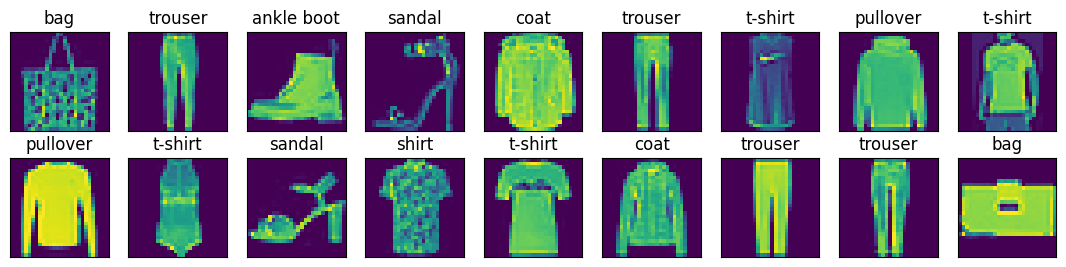

In [7]:
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../../data', train=True, download=True, transform=trans)
mnist_test = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=trans)

#结构：list of tuple (Tensor(1,28,28), label_idx)

# 将数字标签转换为文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[label] for label in labels]

# 画图
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X,y = next(iter(data.DataLoader(mnist_train, batch_size=18, shuffle=True)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));


In [9]:
# 训练准备
batch_size = 256
data_loader_workers = 4
def load_data_fashion_mnist(batch_size,resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../../data',train=True,download=True,transform=trans)
    mnist_test = torchvision.datasets.FashionMNIST(root='../../data',train=False,download=True,transform=trans)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=data_loader_workers),
            data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=data_loader_workers))

train_iter,test_iter = load_data_fashion_mnist(batch_size)
num_input = 784 # 28*28
num_output = 10 # 10 classes
W = torch.normal(0,0.01,size=(num_input,num_output),device=device,dtype=torch.float32,requires_grad=True)
b = torch.zeros(num_output,device=device,dtype=torch.float32,requires_grad=True)

def softmax(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1,keepdim=True)
    return x_exp / partition

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 损失函数，注意这里的两个输入形状和值的意义是不同的
# y_hat是(batch_size,num_output)表示每个类别的概率，y是(batch_size,)表示类别在one-hot编码中的索引
# 学到了：在Tensor的索引中使用Iterable，表示按顺序取数据，比如a[[0,1],1]->[a[0,1],a[1,1]]，a[[0,1],[0,1]]->[a[0,0],a[1,1]]
# 但是使用slice会比较有趣, a[slice(2),1]->[a[0,1],a[1,1]], 但是a[slice(2),slice(2)] 结果会变成一个矩阵
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

def accuracy(y_hat,y):
    y_hat = y_hat.argmax(axis=-1)
    if y.ndim > 1:
        y = y.squeeze(-1)
    y = y.to(y_hat.device)
    return (y_hat == y).sum()


def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


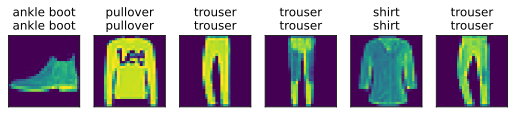

In [14]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    X_dev = X.to(device)
    y_hat = net(X_dev)
    pred_idx = y_hat.argmax(dim=1).detach().cpu()
    trues = get_fashion_mnist_labels(y[:n].tolist())
    preds = get_fashion_mnist_labels(pred_idx[:n].tolist())
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[:n].reshape((n, 28, 28)), 1, n, titles=titles)

predict_ch3(net, test_iter)